## Load Data

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import ipywidgets as widgets
from datetime import timedelta
from IPython.display import Image
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
from mpl_toolkits.mplot3d import Axes3D
% matplotlib inline

In [4]:
df = pd.read_pickle('noNullDF.pkl')

In [5]:
df.columns

Index([u'Visit #', u'Age', u'Sex', u'Race', u'ISS', u'TTA', u'GCS',
       u'Arrival Date', u'Arrival Time', u'ED Disposition', u'ED D/C Date',
       u'ED D/C Time', u'Admit Service', u'Admit Location', u'Toxiclogy',
       u'ETOH', u'Etoh indicator', u'Comorcode', u'LOS (Days)', u'Injury Date',
       u'Injury Type', u'Injury Street', u'Injury Zip', u'Abuse?', u'MOI',
       u'Work Related?', u'Fall Height', u'Dx List', u'Consults',
       u'Discharge Disposition'],
      dtype='object')

## Feature Engineering

In [6]:
def combineDCDateTimes(x):
    try: 
        return pd.Timestamp(str(x['ED D/C Date'].year) +"-"+
            str(x['ED D/C Date'].month) +"-"+
            str(x['ED D/C Date'].day) +"-"+
            str(x['ED D/C Time']))
    except:
        pass

In [7]:
def combineArrivalDateTimes(x):
    try: 
        return pd.Timestamp(str(x['Arrival Date'].year) +"-"+
            str(x['Arrival Date'].month) +"-"+
            str(x['Arrival Date'].day) +"-"+
            str(x['Arrival Time']))
    except:
        pass

In [8]:
def losHours(x):
    try:
        return x['Combined D/C DateTime'] - x['Combined Arrival DateTime']
    except: 
        pass

In [9]:
# Combined D/C DateTime
df['Combined D/C DateTime'] = df.apply(combineDCDateTimes, axis=1)
df['Combined D/C DateTime'].isnull().sum()

0

In [10]:
# Combined Arrival DateTime
df['Combined Arrival DateTime'] = df.apply(combineArrivalDateTimes, axis=1)
df['Combined Arrival DateTime'].isnull().sum()

0

In [11]:
# Arrival Hour
df['Arrival Hour'] = df['Arrival Time'].apply(lambda x: x.hour)

In [12]:
# Discharge Hour
df['ED D/C Hour'] = df['ED D/C Time'].apply(lambda x: x.hour)

In [13]:
# Length of Stay (hours)
df['Length of Stay (hours)'] = df.apply(losHours, axis=1)

# Find the median length of stay in hours. Used this to fill nans in the D/C time and Date spreadsheet:
df['Length of Stay (hours)'].median()

Timedelta('0 days 06:19:00')

In [14]:
# Length of Stay 
df["Length of Stay (minutes)"] = df["Length of Stay (hours)"].apply(lambda x: (x.seconds/60.00)) 

In [15]:
# ETOH Buckets
df['ETOH Buckets'] = df['ETOH'].apply(lambda x: "Under Legal Limit" if x <= 80 
                                  else "Unknown" if x == 'Not Tested' 
                                  else "Over Legal Limit")

# Creating this feature just to visualize the nuance a bit better.
df['ETOH Buckets Plot'] = df['ETOH'].apply(lambda x: 80 if x <= 80 
                                  else 160 if x <= 160 
                                  else 240 if x<=240 
                                  else 320 if x<=320 
                                  else 320 if x<=320 
                                  else 400 if x<=400
                                  else 480 if x<=480
                                  else 560 if x<=560
                                  else "Unknown")

In [16]:
# Fall Height Bins
def createFallHeightBuckets(x):
    if x == 'Unknown/No Fall':
        return x
    elif x <= 5:
        return "5 Feet or Under"
    elif x> 5:
        return "Over 5 Feet"
    
df['Fall Height Buckets'] = df['Fall Height'].apply(createFallHeightBuckets)

In [17]:
# TTA Bins
def createTTABuckets(x):
    if x == 'ND' or x == "IN":
        return "ND/IN"
    elif x <= "P" or x == "C":
        return "Lvl 2/Lvl 3"
    else:
        return "Lvl 1"
    
df['TTA Buckets'] = df['TTA'].apply(createTTABuckets)

In [18]:
# ED Disposition Buckets
def createEDDispositionBuckets(x):
    if x == "Admitted":
        return x
    elif x == 'Discharged to Home or Self-care (Routine Discharge)':
        return "Routine Discharge"
    elif "Died" in x:
        return "Died"
    else:
        return "Other"
    
df["ED Disposition Buckets"] = df["ED Disposition"].apply(createEDDispositionBuckets) 

In [19]:
# Admit Service Buckets
# We do list a bit of information here. Ask lizzie if there's a better way of grouping
def createAdmitServiceBuckets(x):
    if "surgery" in x or "Surgery" in x:
        return "Trauma/Other Surgery"
    elif x == "Patient Not Admitted":
        return x
    elif x == "Orthopedics":
        return x
    else:
        return "Other"

df['Admit Service Buckets'] = df['Admit Service'].apply(createAdmitServiceBuckets)

In [20]:
# Admit Location Buckets
# We do list a bit of information here. Ask lizzie if there's a better way of grouping
def createAdmitLocationBuckets(x):
    if x == "Ward/Floor":
        return x
    elif x == "Intensive/Critical Care Unit" or x == "Emergency Dept." or x == "Operating Room":
        return "ICU/ER/OR"
    else:
        return "Home/Other"

df['Admit Location Buckets'] = df['Admit Location'].apply(createAdmitLocationBuckets)

In [21]:
# Toxicology Buckets
def createToxicologyBuckets(x):
    if "(not tested)" in x:
        return "Not Tested"
    elif x == "No (test confirmed)":
        return "No"
    elif x == "Yes (Prescription)":
        return x
    else:
        return "Yes (Illegal)"

df['Toxiclogy Buckets'] = df['Toxiclogy'].apply(createToxicologyBuckets)

In [22]:
# Discharge Disposition Buckets
def dischargeDispositionBuckets(x):
    if x == 'Discharged to Home or Self-care (Routine Discharge)' or x == 'Home with services':
        return "Discharged Home (routine)"
    elif "Rehab" in x:
        return "Rehabilitation"
    elif "Die" in x or "death" in x:
        return "Died"
    else:
        return "Other"

df['Discharge Disposition Buckets'] = df['Discharge Disposition'].apply(dischargeDispositionBuckets)

In [23]:
# MOI Buckets - used the most common words appearing in MOI to create:
# Counter(" ".join(df["MOI"]).split()).most_common(100)

def createMOIBuckets(x):
    if "Fall" in x or "fall" in x:
        return "Fall"
    elif "Assault" in x:
        return "Victim of Assault"
    elif "collision" in x or "accident" in x or "traffic" in x or "truck" in x or "pick-up" in x or "pick-up" in x \
    or "car" in x or "van" in x or "Car" in x or "driver" in x or "Pedestrian" in x or "cycle" in x:
        return "Motor vehicle Accident"
    else:
        return "Other"

df['MOI Buckets'] = df['MOI'].apply(createMOIBuckets)

In [24]:
# Fall Patient
df["Fall Patient?"] = df["MOI Buckets"].apply(lambda x: 1 if x == "Fall" else 0)

In [25]:
# # Columns to be unpacked:
# trainDFFeatures = pd.DataFrame
# unpackedList = ['Comorcode','Consults']

In [26]:
# Check Data Types:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 47 columns):
Visit #                          1520 non-null int64
Age                              1520 non-null float64
Sex                              1520 non-null object
Race                             1520 non-null object
ISS                              1520 non-null int64
TTA                              1520 non-null object
GCS                              1520 non-null int64
Arrival Date                     1520 non-null datetime64[ns]
Arrival Time                     1520 non-null object
ED Disposition                   1520 non-null object
ED D/C Date                      1520 non-null datetime64[ns]
ED D/C Time                      1520 non-null object
Admit Service                    1520 non-null object
Admit Location                   1520 non-null object
Toxiclogy                        1520 non-null object
ETOH                             1520 non-null object
Etoh indicator 

In [27]:
df.columns

Index([                      u'Visit #',                           u'Age',
                                 u'Sex',                          u'Race',
                                 u'ISS',                           u'TTA',
                                 u'GCS',                  u'Arrival Date',
                        u'Arrival Time',                u'ED Disposition',
                         u'ED D/C Date',                   u'ED D/C Time',
                       u'Admit Service',                u'Admit Location',
                           u'Toxiclogy',                          u'ETOH',
                      u'Etoh indicator',                     u'Comorcode',
                          u'LOS (Days)',                   u'Injury Date',
                         u'Injury Type',                 u'Injury Street',
                          u'Injury Zip',                        u'Abuse?',
                                 u'MOI',                 u'Work Related?',
                         

## EDA

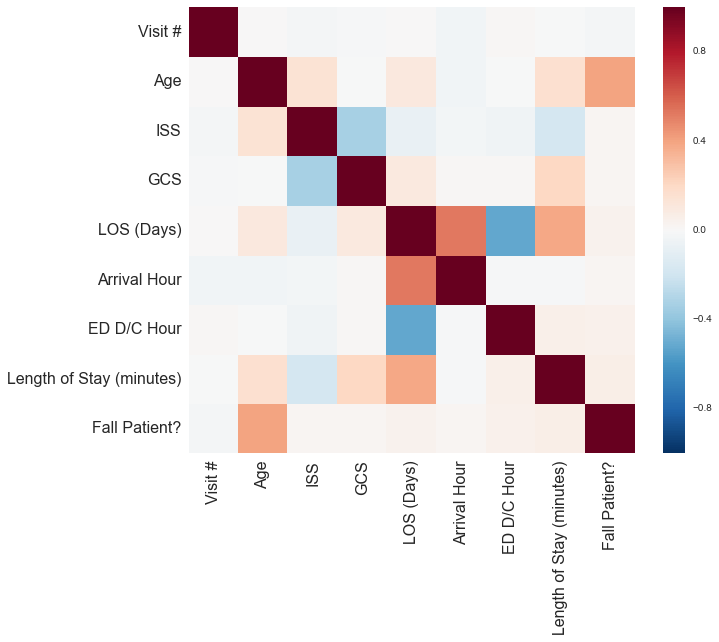

In [28]:
plt.rcParams['figure.figsize'] = (10,8)
plt.tick_params(axis='both', which='major', labelsize=16)
sns.heatmap(df.corr());

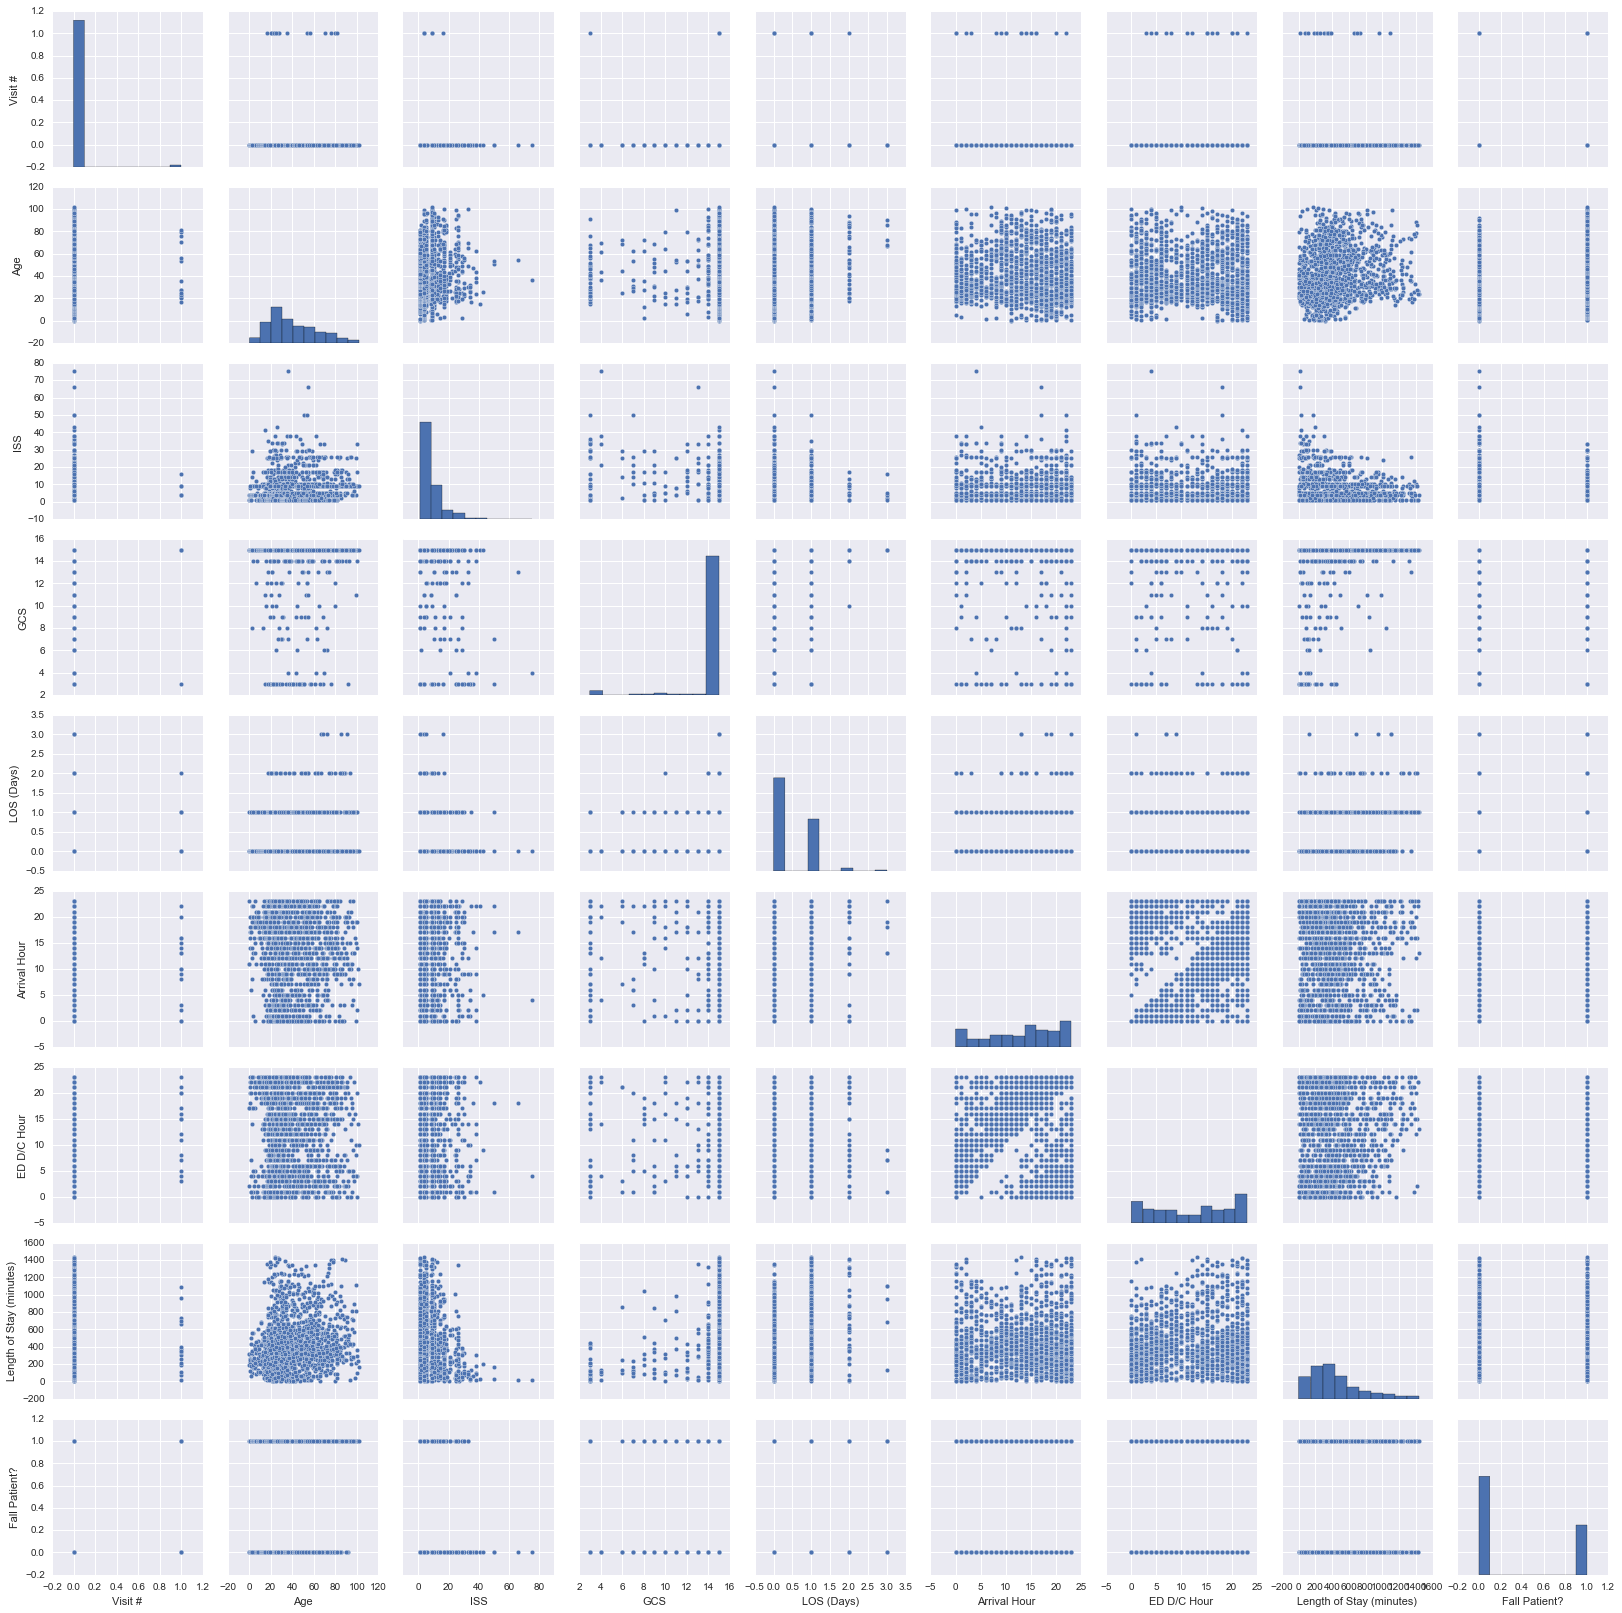

In [29]:
sns.pairplot(df);

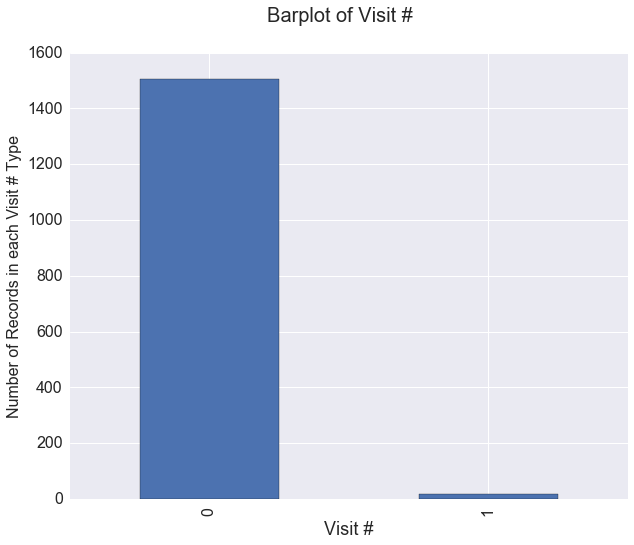

In [30]:
fig = plt.figure()
fig.suptitle('Barplot of Visit #', fontsize=20)
plt.xlabel('Visit #', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Number of Records in each Visit # Type', fontsize=16)
df['Visit #'].value_counts().plot(kind='bar');

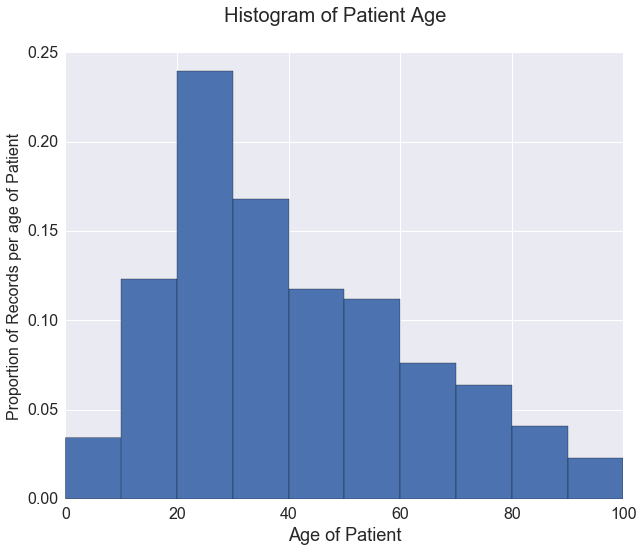

In [31]:
fig = plt.figure()
fig.suptitle('Histogram of Patient Age', fontsize=20)
plt.xlabel('Age of Patient', fontsize=18)
plt.ylabel('Proportion of Records per age of Patient', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
weights = np.ones_like(df['Age'])/float(len(df['Age']))
plt.hist(df['Age'], weights=weights, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]);

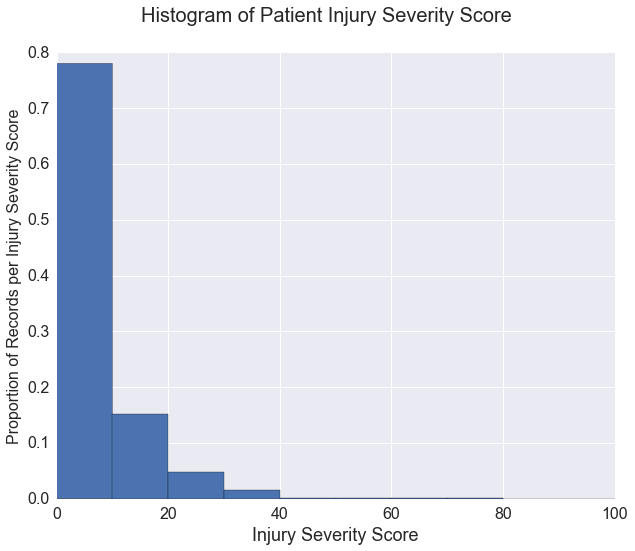

In [32]:
fig = plt.figure()
fig.suptitle('Histogram of Patient Injury Severity Score', fontsize=20)
plt.xlabel('Injury Severity Score', fontsize=18)
plt.ylabel('Proportion of Records per Injury Severity Score', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
weights = np.ones_like(df['ISS'])/float(len(df['ISS']))
plt.hist(df['ISS'], weights=weights, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]);

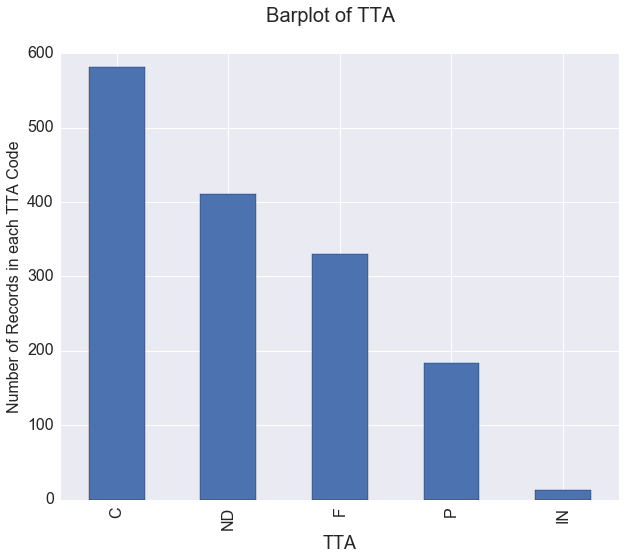

In [33]:
fig = plt.figure()
fig.suptitle('Barplot of TTA', fontsize=20)
plt.xlabel('TTA', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Number of Records in each TTA Code', fontsize=16)
df['TTA'].value_counts().plot(kind='bar');

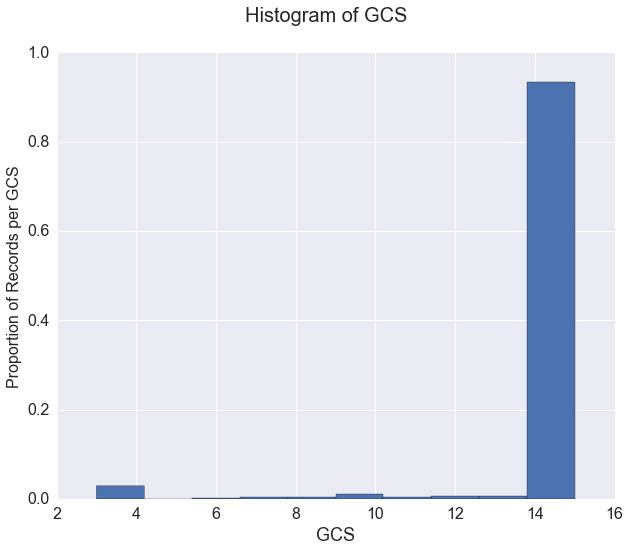

In [34]:
fig = plt.figure()
fig.suptitle('Histogram of GCS', fontsize=20)
plt.xlabel('GCS', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Proportion of Records per GCS', fontsize=16)
weights = np.ones_like(df['GCS'])/float(len(df['GCS']))
plt.hist(df['GCS'], weights=weights, bins=10);

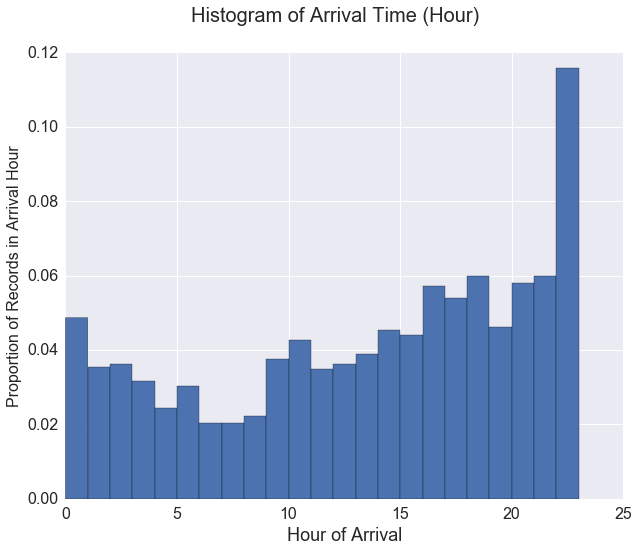

In [35]:
fig = plt.figure()
fig.suptitle('Histogram of Arrival Time (Hour)', fontsize=20)
plt.xlabel('Hour of Arrival', fontsize=18)
plt.ylabel('Proportion of Records in Arrival Hour', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
weights = np.ones_like(df['Arrival Hour'])/float(len(df['Arrival Hour']))
plt.hist(df['Arrival Hour'], weights=weights, bins=len(range(23)));

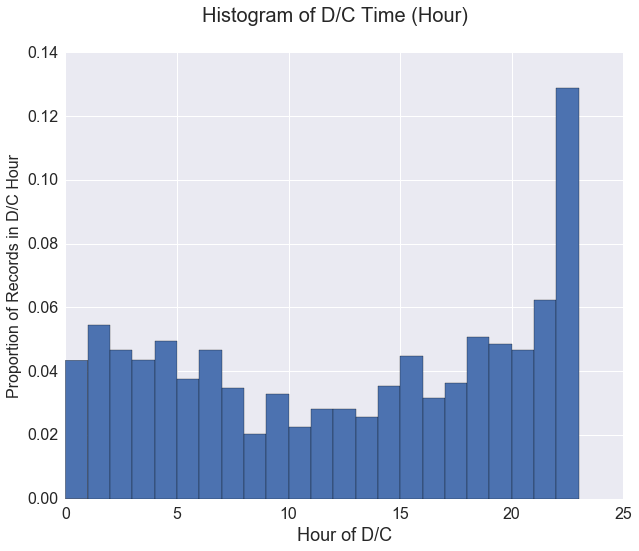

In [36]:
fig = plt.figure()
fig.suptitle('Histogram of D/C Time (Hour)', fontsize=20)
plt.xlabel('Hour of D/C', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Proportion of Records in D/C Hour', fontsize=16)
weights = np.ones_like(df['ED D/C Hour'])/float(len(df['ED D/C Hour']))
plt.hist(df['ED D/C Hour'], weights=weights, bins=len(range(23)));

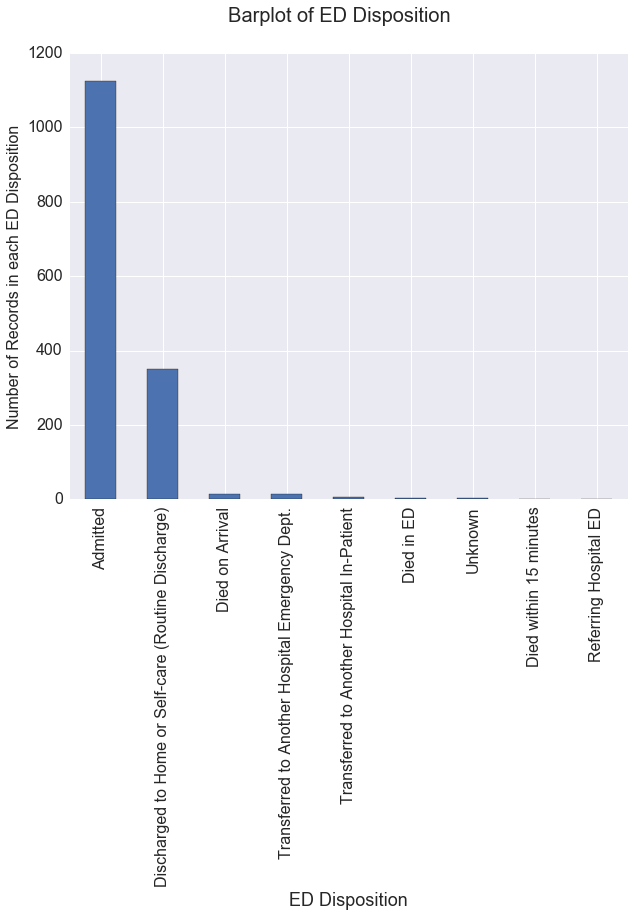

In [37]:
fig = plt.figure()
fig.suptitle('Barplot of ED Disposition', fontsize=20)
plt.xlabel('ED Disposition', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Number of Records in each ED Disposition', fontsize=16)
df['ED Disposition'].value_counts().plot(kind='bar');

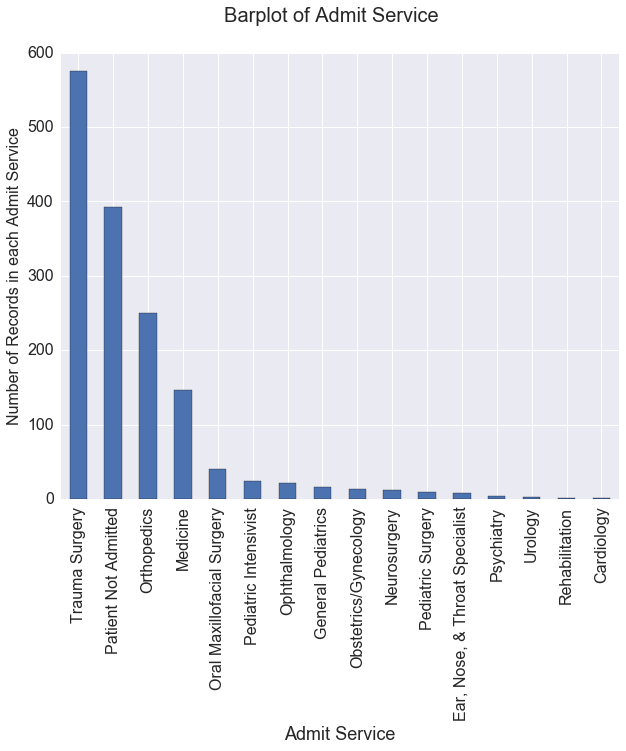

In [38]:
fig = plt.figure()
fig.suptitle('Barplot of Admit Service', fontsize=20)
plt.xlabel('Admit Service', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Number of Records in each Admit Service', fontsize=16)
df['Admit Service'].value_counts().plot(kind='bar');

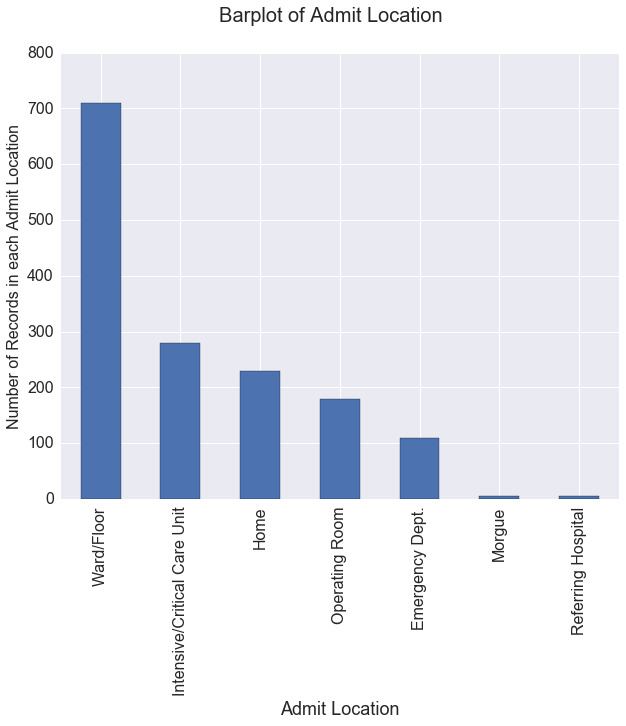

In [39]:
fig = plt.figure()
fig.suptitle('Barplot of Admit Location', fontsize=20)
plt.xlabel('Admit Location', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Number of Records in each Admit Location', fontsize=16)
df['Admit Location'].value_counts().plot(kind='bar');

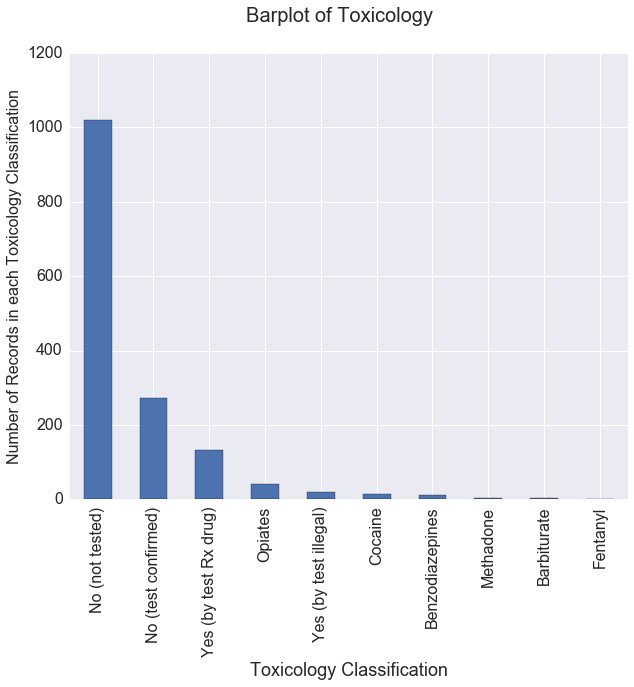

In [40]:
fig = plt.figure()
fig.suptitle('Barplot of Toxicology', fontsize=20)
plt.xlabel('Toxicology Classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Number of Records in each Toxicology Classification', fontsize=16)
df['Toxiclogy'].value_counts().plot(kind='bar');

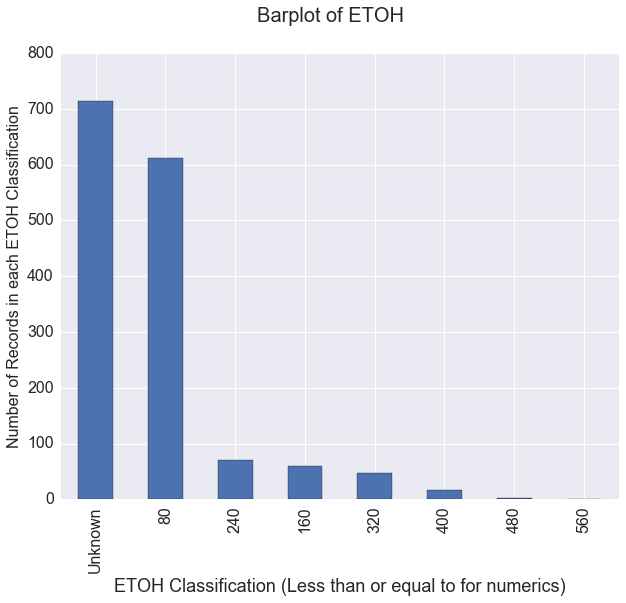

In [41]:
fig = plt.figure()
fig.suptitle('Barplot of ETOH', fontsize=20)
plt.xlabel('ETOH Classification (Less than or equal to for numerics)', fontsize=18)
plt.ylabel('Number of Records in each ETOH Classification', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
df['ETOH Buckets Plot'].value_counts().plot(kind='bar');

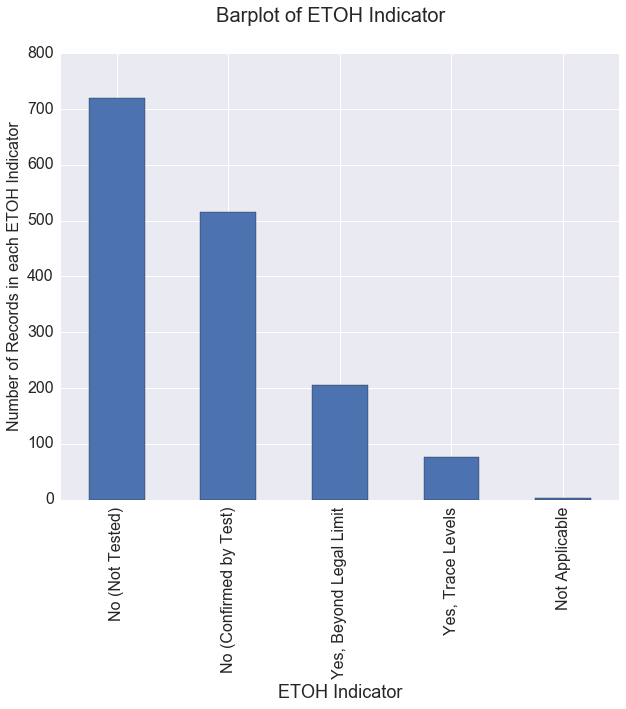

In [42]:
fig = plt.figure()
fig.suptitle('Barplot of ETOH Indicator', fontsize=20)
plt.xlabel('ETOH Indicator', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Number of Records in each ETOH Indicator', fontsize=16)
df['Etoh indicator'].value_counts().plot(kind='bar');

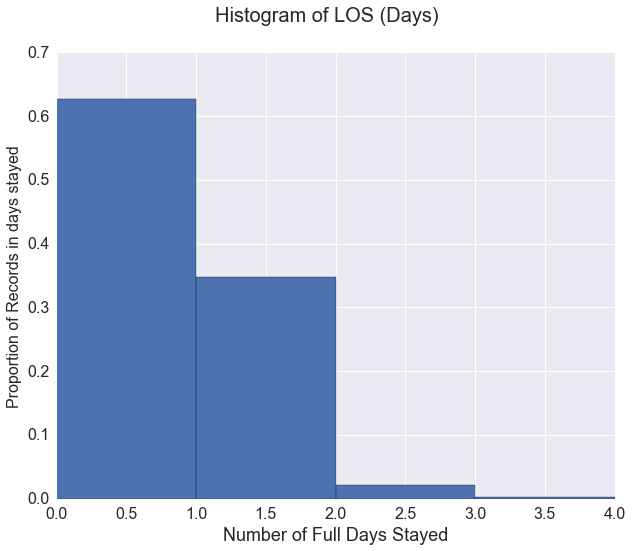

In [43]:
fig = plt.figure()
fig.suptitle('Histogram of LOS (Days)', fontsize=20)
plt.xlabel('Number of Full Days Stayed', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Proportion of Records in days stayed', fontsize=16)
weights = np.ones_like(df['LOS (Days)'])/float(len(df['LOS (Days)']))
plt.hist(df['LOS (Days)'], weights=weights, bins=[0,1,2,3,4]);

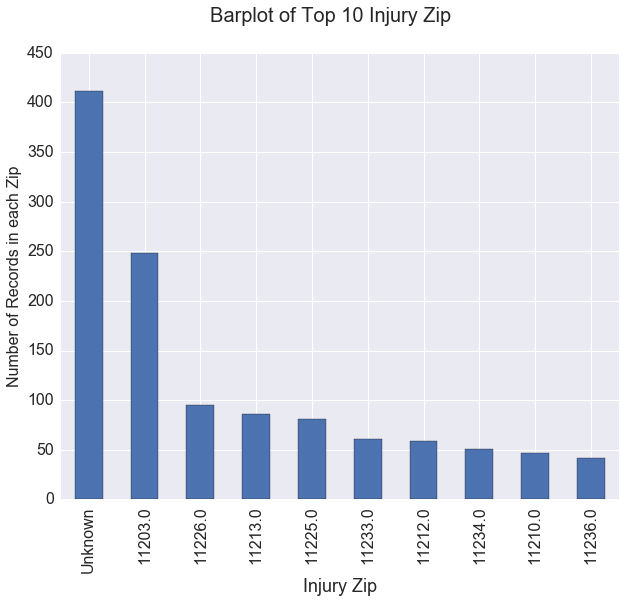

In [44]:
# Use Tableau
fig = plt.figure()
plt.rcParams['figure.figsize'] = (14,12)
fig.suptitle('Barplot of Top 10 Injury Zip', fontsize=20)
plt.xlabel('Injury Zip', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Number of Records in each Zip', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
df['Injury Zip'].value_counts().head(10).plot(kind='bar');

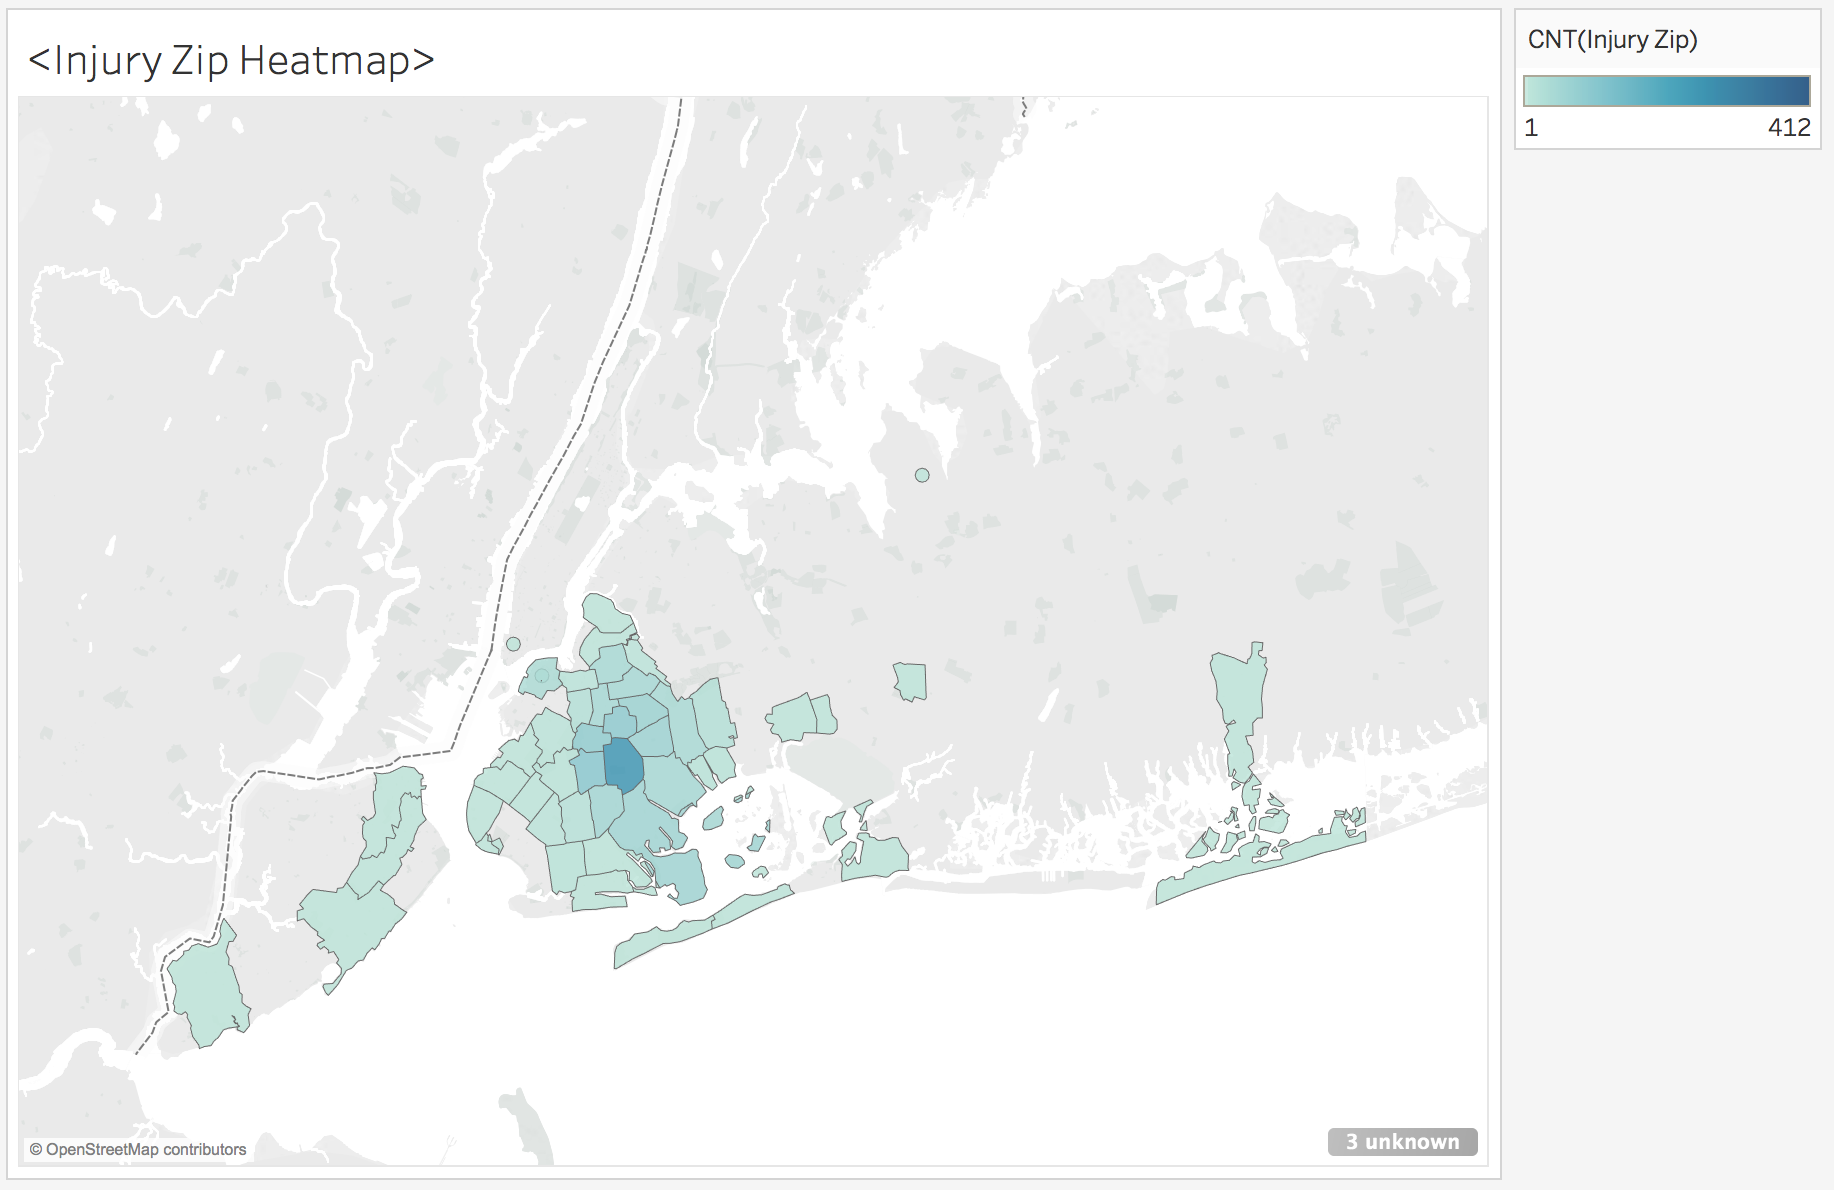

In [45]:
# 11203 (East Flatbush) Reported the most injuries and the bordering zips were the highest on the heatmap:
Image("https://dl.dropboxusercontent.com/s/s3ib25wbpd0znjx/Screenshot%202017-01-19%2019.21.56.png")

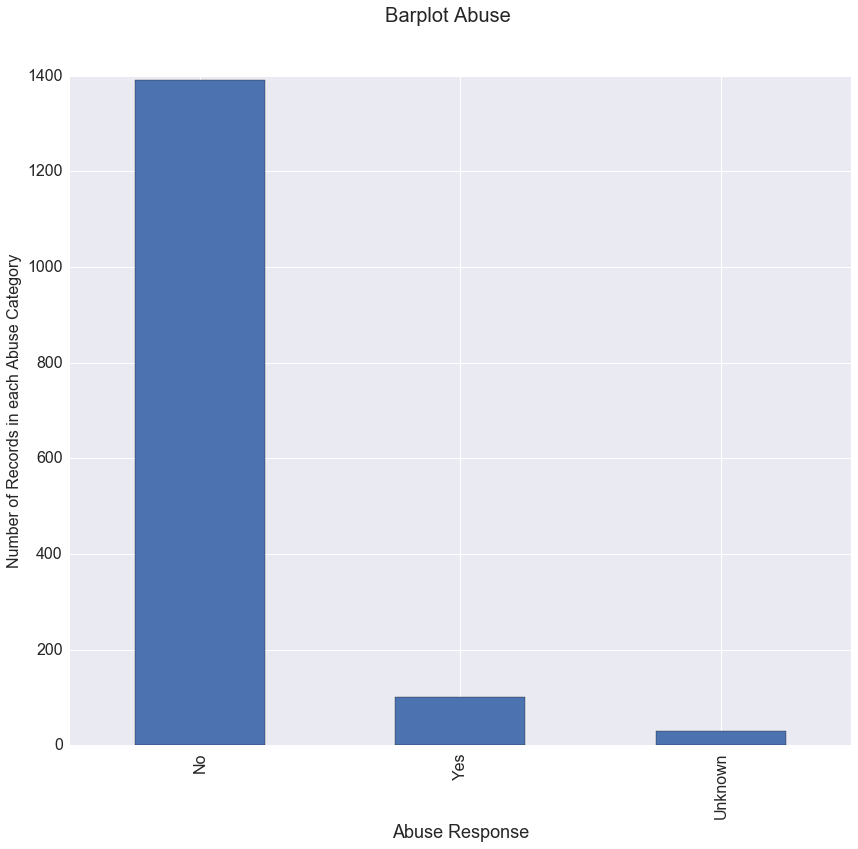

In [46]:
fig = plt.figure()
fig.suptitle('Barplot Abuse', fontsize=20)
plt.xlabel('Abuse Response', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Number of Records in each Abuse Category', fontsize=16)
df['Abuse?'].value_counts().plot(kind='bar');

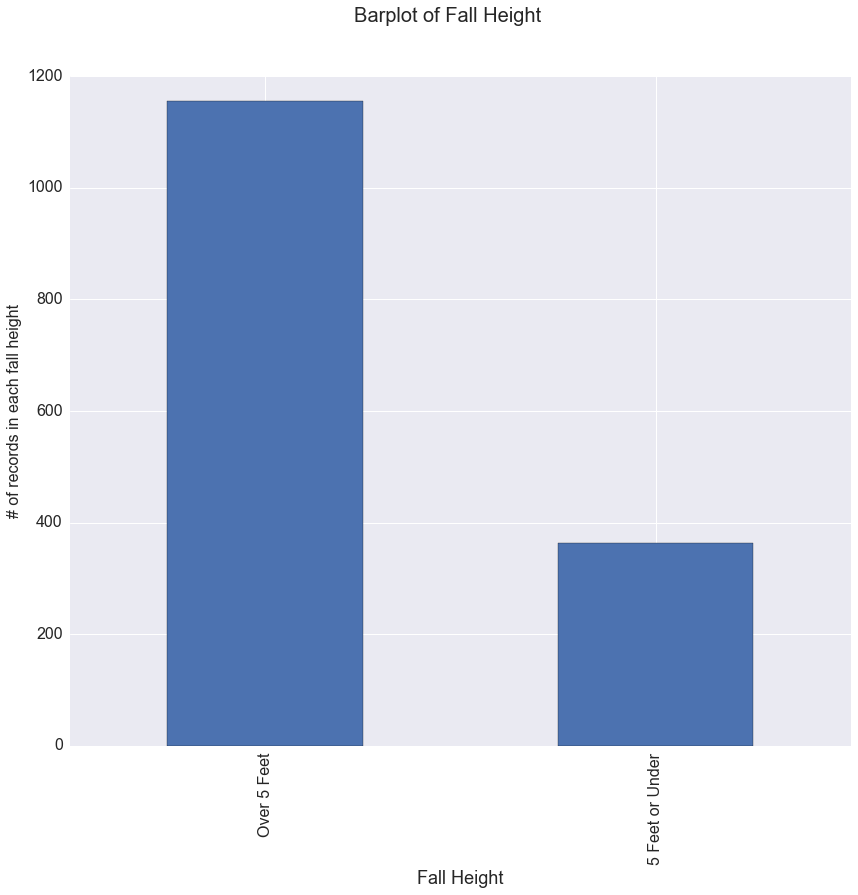

In [47]:
fig = plt.figure()
fig.suptitle('Barplot of Fall Height', fontsize=20)
plt.xlabel('Fall Height', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('# of records in each fall height', fontsize=16)
df['Fall Height Buckets'].value_counts().plot(kind='bar');

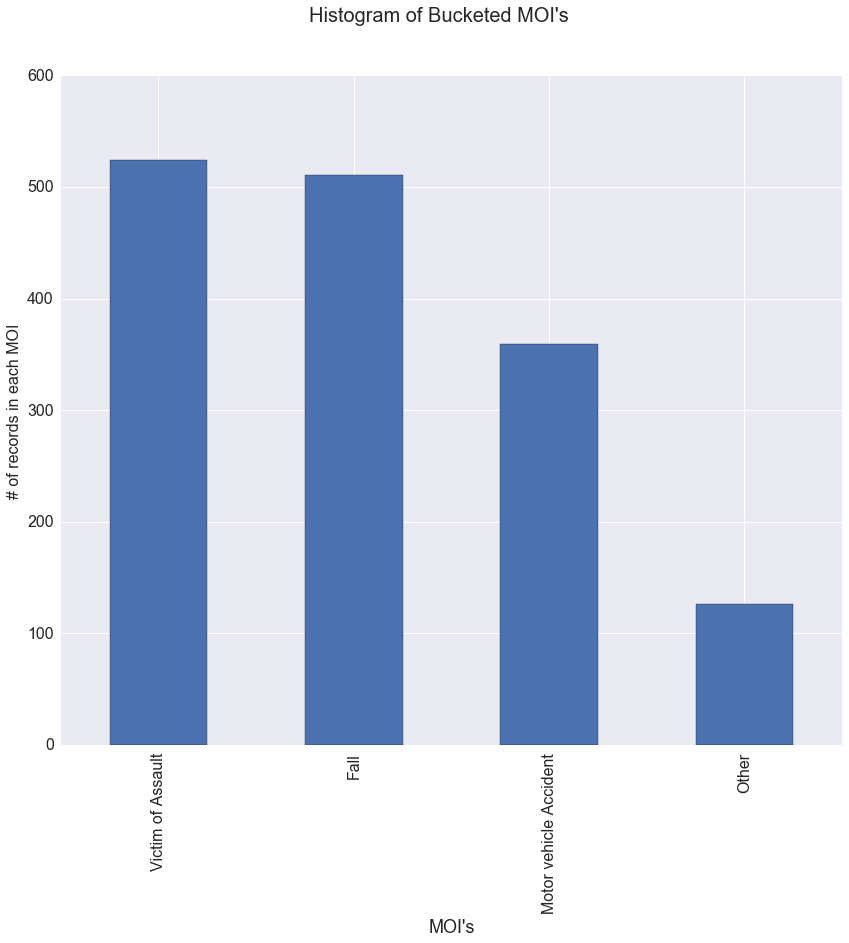

In [48]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = (9,7)
fig.suptitle("Histogram of Bucketed MOI's", fontsize=20)
plt.xlabel("MOI's", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('# of records in each MOI', fontsize=16)
df['MOI Buckets'].value_counts().plot(kind='bar');

# MODELS

In [49]:
# Going to drop a few more feautures that don't seem to be impactful to reduce dimensionality:

df.drop("Visit #", axis=1, inplace=True)
# DATA CAPTURED IN ETOH FEATURE
df.drop("Etoh indicator", axis=1, inplace=True)

# RandomForest classifier on Mechanism of Injury == Fall using label encoder

In [50]:
# Create Model for DataFrame:
featuresDF = df.drop(["LOS (Days)","Arrival Date", "Arrival Time", 'ED D/C Date', 'ED D/C Time',
                    "Comorcode", "Injury Date", "Injury Street",
                     "Injury Zip", 'Combined D/C DateTime',"Dx List", 
                    "Consults", "ETOH Buckets Plot", "Discharge Disposition", 'Combined Arrival DateTime', 
                      "Length of Stay (hours)",
                    "MOI Buckets", "Toxiclogy Buckets", "Admit Location Buckets", "Fall Height",
                     "Admit Service Buckets", "ED Disposition Buckets", 
                      "TTA Buckets", "Fall Height Buckets","Fall Patient?",
                     "ETOH Buckets", "MOI"], axis = 1)

labelsSeries = df["Fall Patient?"]

fullDF = pd.concat([featuresDF, labelsSeries], axis=1)

encodedFullDF = pd.DataFrame()

In [51]:
# Encode Features:
featuresToEncode = ["Sex", "Race", "Injury Type", "Abuse?", "Work Related?", "ETOH", 'Admit Service',
                   "TTA", "ED Disposition", "Admit Service", "Admit Location", "ISS",
                   "Toxiclogy", "Discharge Disposition Buckets"]

for feature in featuresToEncode:
    featuresDF[feature] = LabelEncoder().fit_transform(featuresDF[feature])

for feature in fullDF:
    encodedFullDF[feature] = LabelEncoder().fit_transform(fullDF[feature])

In [52]:
# Scale Dataframes

encodedFullDFCols = encodedFullDF.columns
columns = featuresDF.columns
scaler = MinMaxScaler()

#scale features
featuresDF = scaler.fit_transform(featuresDF)
featuresDF = pd.DataFrame(columns=columns, data=featuresDF)

#encode and scale labels
# labelsSeries = LabelEncoder().fit_transform(labelsSeries)
# labelsSeries = scaler.fit_transform(labelsSeries)
# labelsSeries = pd.DataFrame(columns=columns, data=labelsSeries)

encodedFullDF = scaler.fit_transform(encodedFullDF)
encodedFullDF = pd.DataFrame(columns=encodedFullDFCols, data=encodedFullDF)

In [53]:
# Let's see what the feature importances are to reduce dimensionality:

X, y = encodedFullDF.groupby('Fall Patient?').head(510).iloc[:,:-1], encodedFullDF.groupby('Fall Patient?').head(510).iloc[:,-1:]


forest = RandomForestClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [54]:
s = cross_val_score(forest, featuresDF, labelsSeries, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest Cros Val", s.mean().round(3), s.std().round(3)))

Random Forest Cros Val Score:	0.793 ± 0.031


In [55]:
def aFunction(x):
    if x["predicted"] == x["actual"]:
        return 1
    else:
        return 0

In [56]:
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature name: %s (%f)" % (f + 1, X.columns[f], importances[indices[f]]))

Feature ranking:
1. feature name: Age (0.211287)
2. feature name: Sex (0.087311)
3. feature name: Race (0.084715)
4. feature name: ISS (0.083197)
5. feature name: TTA (0.064621)
6. feature name: GCS (0.064430)
7. feature name: ED Disposition (0.064239)
8. feature name: Admit Service (0.057350)
9. feature name: Admit Location (0.056091)
10. feature name: Toxiclogy (0.041352)
11. feature name: ETOH (0.035735)
12. feature name: Injury Type (0.033593)
13. feature name: Abuse? (0.030407)
14. feature name: Work Related? (0.023960)
15. feature name: Arrival Hour (0.019511)
16. feature name: ED D/C Hour (0.016196)
17. feature name: Length of Stay (minutes) (0.015363)
18. feature name: Discharge Disposition Buckets (0.010641)


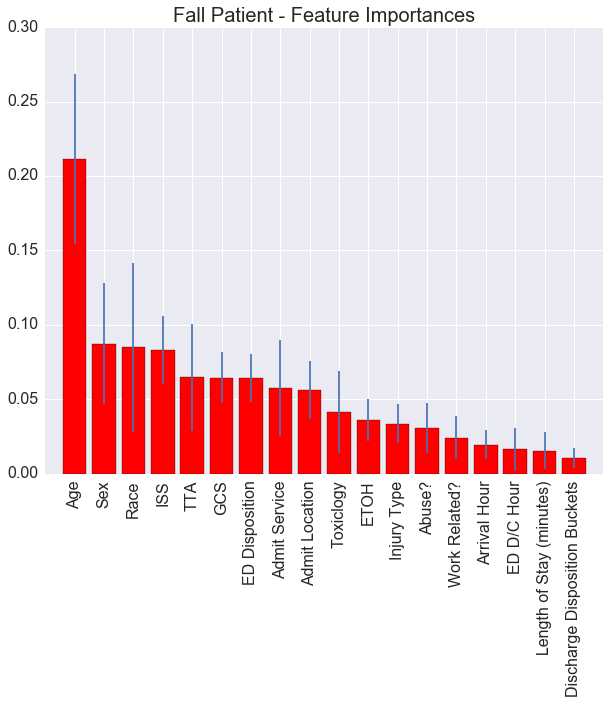

In [57]:
# Plot the feature importances of the forest
plt.rcParams['figure.figsize'] = (10,8)
plt.figure()
plt.title("Fall Patient - Feature Importances", fontsize=20)
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(rotation="90")
plt.xticks(range(X.shape[1]), X.columns)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlim([-1, X.shape[1]])
plt.show()

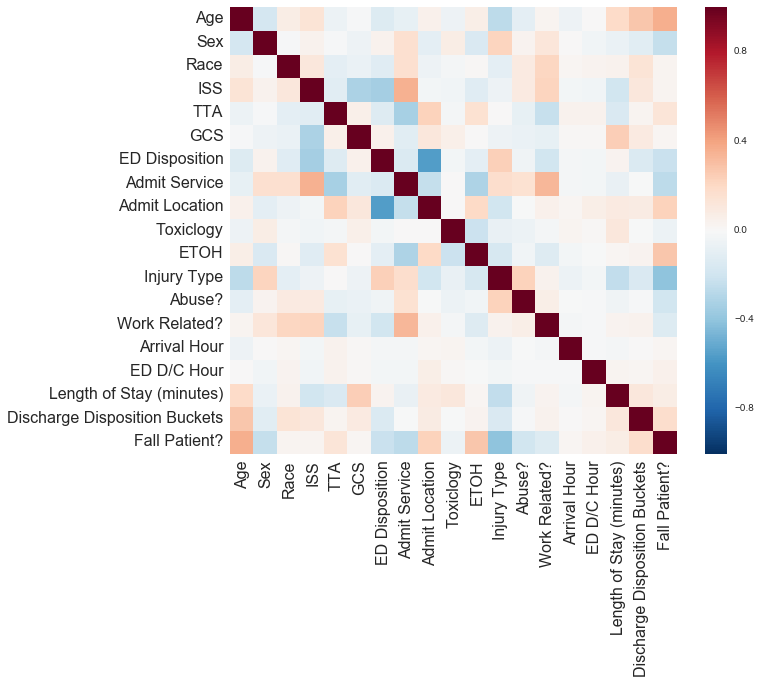

In [58]:
plt.rcParams['figure.figsize'] = (10,8)
plt.tick_params(axis='both', which='major', labelsize=16)
sns.heatmap(encodedFullDF.corr());

In [59]:
fullDF["Injury Type"]

0       Blunt          
1       Blunt          
2       Blunt          
3       Blunt          
4       Penetrating    
5       Blunt          
6       Penetrating    
7       Penetrating    
8       Penetrating    
9       Blunt          
10      Blunt          
11      Blunt          
12      Penetrating    
13      Blunt          
14      Blunt          
15      Blunt          
16      Blunt          
17      Blunt          
18      Blunt          
19      Blunt          
20      Blunt          
21      Penetrating    
22      Penetrating    
23      Penetrating    
24      Blunt          
25      Blunt          
26      Blunt          
27      Penetrating    
28      Blunt          
29      Blunt          
             ...       
1490    Blunt          
1491    Penetrating    
1492    Blunt          
1493    Penetrating    
1494    Penetrating    
1495    Blunt          
1496    Blunt          
1497    Penetrating    
1498    Blunt          
1499    Penetrating    
1500    Blunt   

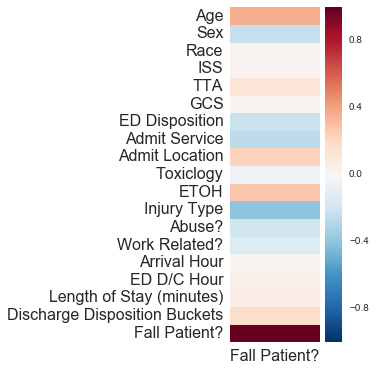

In [61]:
plt.rcParams['figure.figsize'] = (2,6)
plt.tick_params(axis='both', which='major', labelsize=16)
sns.heatmap(encodedFullDF.corr().ix["Fall Patient?"].to_frame());

# What do fall patients look like versus non-fall victims?

## Fall victims are: 

- Older (mean 54.25 yrs old versus 34.48 years old)
- More likely to be female than male - Women make up 43% of fall patients but just 21% of non-fall patients
- Otherwise, quite similar. 


In [62]:
fallPatients = pd.DataFrame(fullDF[fullDF["Fall Patient?"]==1]).reset_index(drop=True)
notFallPatients = pd.DataFrame(fullDF[fullDF["Fall Patient?"]==0]).reset_index(drop=True)
fallPatientsEncoded = pd.DataFrame(encodedFullDF[encodedFullDF["Fall Patient?"]==1]).reset_index(drop=True)
notFallPatientsEncoded = pd.DataFrame(encodedFullDF[encodedFullDF["Fall Patient?"]==0]).reset_index(drop=True)

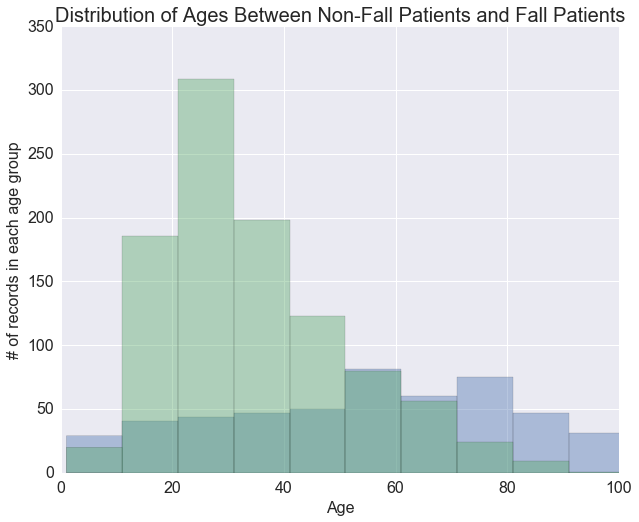

In [63]:
# For the plot below, focus more on the shape (skew) of the distributions than the heights - the records are unbalanced.
plt.rcParams['figure.figsize'] = (10,8)
fig, ax = plt.subplots()
plt.title("Distribution of Ages Between Non-Fall Patients and Fall Patients", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('# of records in each age group', fontsize=16)
plt.xlabel('Age', fontsize=16)
for a in [fallPatients['Age'], notFallPatients['Age']]:
    sns.distplot(a, bins=range(1, 110, 10), ax=ax, kde=False)
ax.set_xlim([0, 100]);

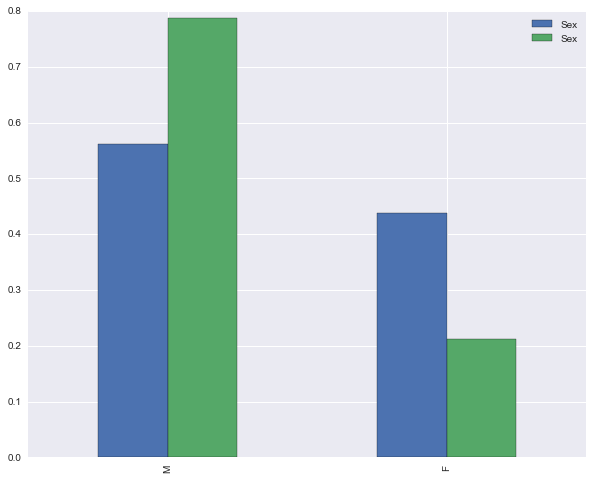

In [64]:
sexComparison = pd.concat([fallPatients['Sex'], notFallPatients['Sex']], axis=1)
sexComparison.columns.values[0] = 'Fall Sex'
sexComparison.columns.values[1] = 'Not Fall Sex'
sexComparisonVC = pd.concat([fallPatients['Sex'].value_counts()/511, notFallPatients['Sex'].value_counts()/1009], axis=1)

plt.rcParams['figure.figsize'] = (10,8)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)
# plt.legend(labels=["Fall Pateints", 'Not Fall Patients'])
sexComparisonVC.plot(kind="bar");
# Blue == Fall Patients


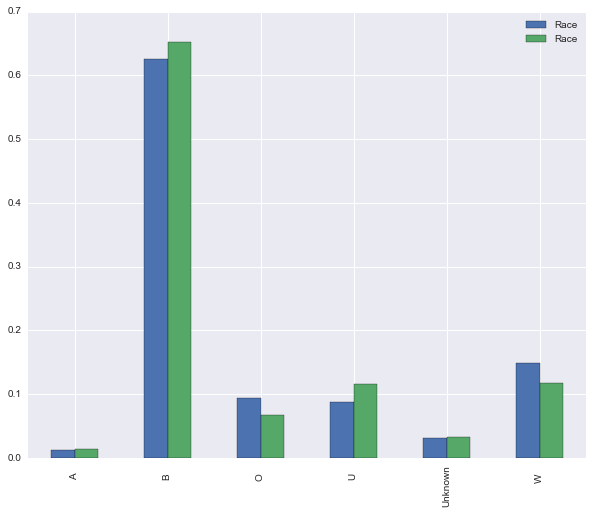

In [65]:
sexComparison = pd.concat([fallPatients['Race'], notFallPatients['Race']], axis=1)
# sexComparison.columns.values[0] = 'Fall Sex'
# sexComparison.columns.values[1] = 'Not Fall Sex'
sexComparisonVC = pd.concat([fallPatients['Race'].value_counts()/511, notFallPatients['Race'].value_counts()/1009], axis=1)

plt.rcParams['figure.figsize'] = (10,8)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)
# plt.legend(labels=["Fall Pateints", 'Not Fall Patients'])
sexComparisonVC.plot(kind="bar");
# Blue == Fall Patients

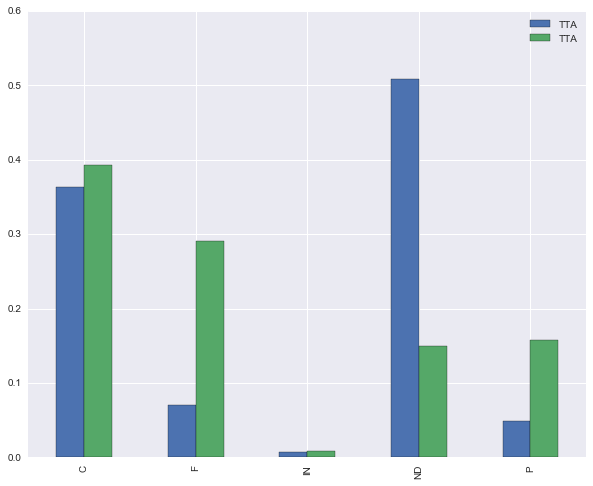

In [66]:
sexComparison = pd.concat([fallPatients['TTA'], notFallPatients['TTA']], axis=1)
# sexComparison.columns.values[0] = 'Fall Sex'
# sexComparison.columns.values[1] = 'Not Fall Sex'
sexComparisonVC = pd.concat([fallPatients['TTA'].value_counts()/511, notFallPatients['TTA'].value_counts()/1009], axis=1)

plt.rcParams['figure.figsize'] = (10,8)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)
# plt.legend(labels=["Fall Pateints", 'Not Fall Patients'])
sexComparisonVC.plot(kind="bar");
## BLUE == FALL PATIENTS

# Random Forest classifier on Discharge Disposition Buckets using label encoder

In [84]:
# Create Model for DataFrame:
featuresDF = df.drop(["LOS (Days)","Arrival Date", "Arrival Time", 'ED D/C Date', 'ED D/C Time',
                    "Comorcode", "Injury Date", "Injury Street",
                     "Injury Zip", 'Combined D/C DateTime',"Dx List", 
                    "Consults", "ETOH Buckets Plot", "Discharge Disposition", 'Combined Arrival DateTime', "Length of Stay (hours)",
                    "MOI", "Toxiclogy Buckets", "Admit Location Buckets", "Fall Height", "Discharge Disposition Buckets",
                     "Admit Service Buckets", "ED Disposition Buckets", "TTA Buckets", "Fall Height Buckets","Fall Patient?",
                     "ETOH Buckets"], axis = 1)

labelsSeries = df["Discharge Disposition Buckets"]

fullDF = pd.concat([featuresDF, labelsSeries], axis=1)

encodedFullDF = pd.DataFrame()

In [87]:
# Encode Features:
featuresToEncode = ["Sex", "Race", "Injury Type", "Abuse?", "Work Related?", "ETOH", 'Admit Service', "ISS",
                   "TTA", "ED Disposition", "Admit Service", "Admit Location", "MOI Buckets",
                   "Toxiclogy"]

for feature in featuresToEncode:
    featuresDF[feature] = LabelEncoder().fit_transform(featuresDF[feature])

for feature in fullDF:
    encodedFullDF[feature] = LabelEncoder().fit_transform(fullDF[feature])

In [88]:
# Scale Dataframes

encodedFullDFCols = encodedFullDF.columns
columns = featuresDF.columns
scaler = MinMaxScaler()

#scale features
featuresDF = scaler.fit_transform(featuresDF)
featuresDF = pd.DataFrame(columns=columns, data=featuresDF)

#encode and scale labels
# labelsSeries = LabelEncoder().fit_transform(labelsSeries)
# labelsSeries = scaler.fit_transform(labelsSeries)

# labelsSeries = pd.DataFrame(columns=columns, data=labelsSeries)

encodedFullDF = scaler.fit_transform(encodedFullDF)
encodedFullDF = pd.DataFrame(columns=encodedFullDFCols, data=encodedFullDF)

In [89]:
# Let's see what the feature importances are to reduce dimensionality:

X, y = encodedFullDF.groupby('Discharge Disposition Buckets').head(56).iloc[:,:-1], fullDF.groupby('Discharge Disposition Buckets').head(56).ix[:,"Discharge Disposition Buckets"]

forest = RandomForestClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [90]:
labelsSeries.unique()

array(['Discharged Home (routine)', 'Other', 'Rehabilitation', 'Died'], dtype=object)

In [91]:
s = cross_val_score(forest, featuresDF, labelsSeries, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest Cros Val", s.mean().round(3), s.std().round(3)))

Random Forest Cros Val Score:	0.649 ± 0.059


In [92]:
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature name: %s (%f)" % (f + 1, X.columns[f], importances[indices[f]]))

Feature ranking:
1. feature name: Age (0.146379)
2. feature name: Sex (0.128842)
3. feature name: Race (0.099228)
4. feature name: ISS (0.094716)
5. feature name: TTA (0.089439)
6. feature name: GCS (0.071787)
7. feature name: ED Disposition (0.041812)
8. feature name: Admit Service (0.040095)
9. feature name: Admit Location (0.038971)
10. feature name: Toxiclogy (0.038030)
11. feature name: ETOH (0.036389)
12. feature name: Injury Type (0.034015)
13. feature name: Abuse? (0.031825)
14. feature name: Work Related? (0.029222)
15. feature name: Arrival Hour (0.026773)
16. feature name: ED D/C Hour (0.019655)
17. feature name: Length of Stay (minutes) (0.017752)
18. feature name: MOI Buckets (0.015071)


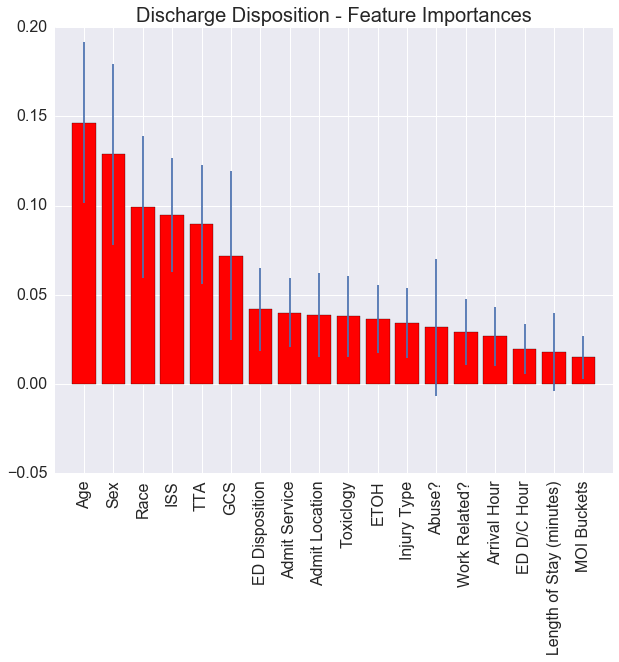

In [93]:
# Plot the feature importances of the forest
plt.rcParams['figure.figsize'] = (10,8)
plt.figure()
plt.title("Discharge Disposition - Feature Importances", fontsize=20)
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(rotation="90")
plt.xticks(range(X.shape[1]), X.columns)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlim([-1, X.shape[1]])
plt.show()

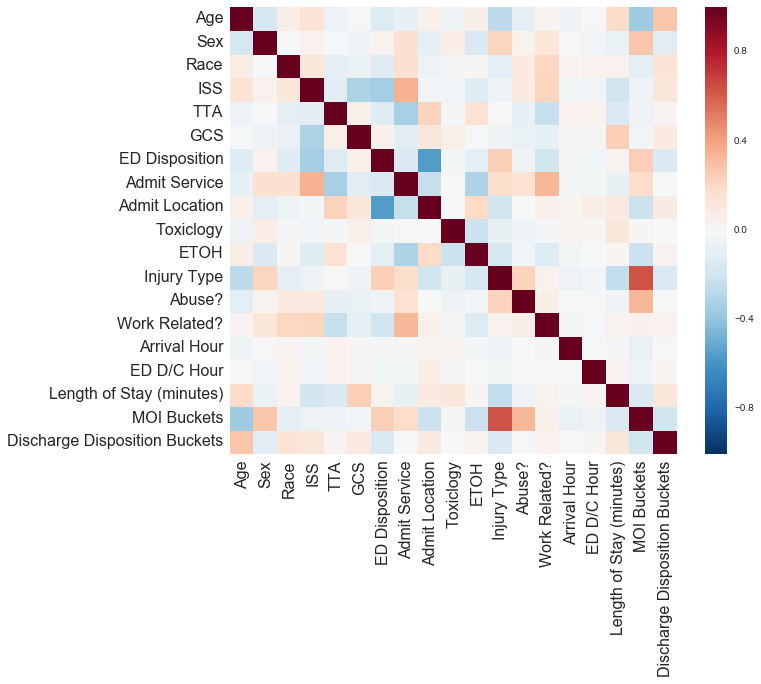

In [94]:
plt.rcParams['figure.figsize'] = (10,8)
plt.tick_params(axis='both', which='major', labelsize=16)
sns.heatmap(encodedFullDF.corr());

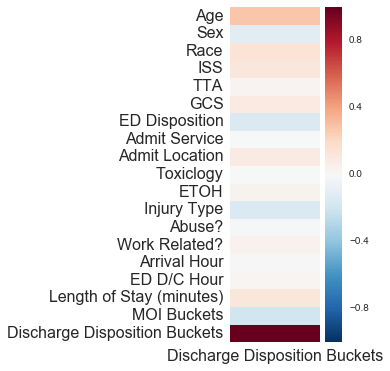

In [95]:
plt.rcParams['figure.figsize'] = (2,6)
plt.tick_params(axis='both', which='major', labelsize=16)
sns.heatmap(encodedFullDF.corr().ix["Discharge Disposition Buckets"].to_frame());

# What do patients of different discharge dispositions look like?

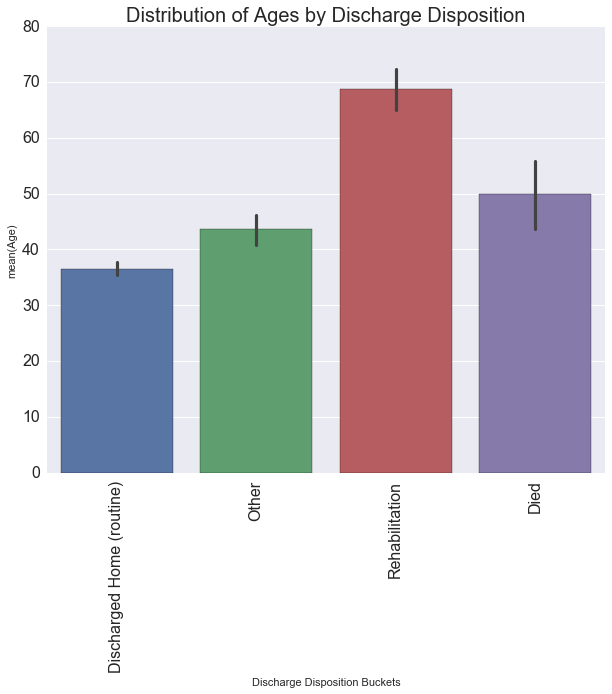

In [96]:
# Age
plt.rcParams['figure.figsize'] = (10,8)
plt.title("Distribution of Ages by Discharge Disposition", fontsize=20)
plt.xticks(rotation="90")
plt.tick_params(axis='both', which='major', labelsize=16)
sns.barplot(x=fullDF['Discharge Disposition Buckets'], y=fullDF['Age'], data = fullDF);

In [97]:
Discharge = pd.DataFrame(fullDF[fullDF["Discharge Disposition Buckets"]=="Discharged Home (routine)"]).reset_index(drop=True)
Died = pd.DataFrame(fullDF[fullDF["Discharge Disposition Buckets"]=="Died"]).reset_index(drop=True)
Other = pd.DataFrame(fullDF[fullDF["Discharge Disposition Buckets"]=="Other"]).reset_index(drop=True)
Rehab = pd.DataFrame(fullDF[fullDF["Discharge Disposition Buckets"]=="Rehabilitation"]).reset_index(drop=True)
Discharge = Discharge["Sex"]
Died = Died["Sex"]
Other = Other["Sex"]
Rehab = Rehab["Sex"]
# notFallPatients = pd.DataFrame(fullDF[fullDF["Fall Patient?"]==0]).reset_index(drop=True)
# fallPatientsEncoded = pd.DataFrame(encodedFullDF[encodedFullDF["Fall Patient?"]==1]).reset_index(drop=True)
# notFallPatientsEncoded = pd.DataFrame(encodedFullDF[encodedFullDF["Fall Patient?"]==0]).reset_index(drop=True)

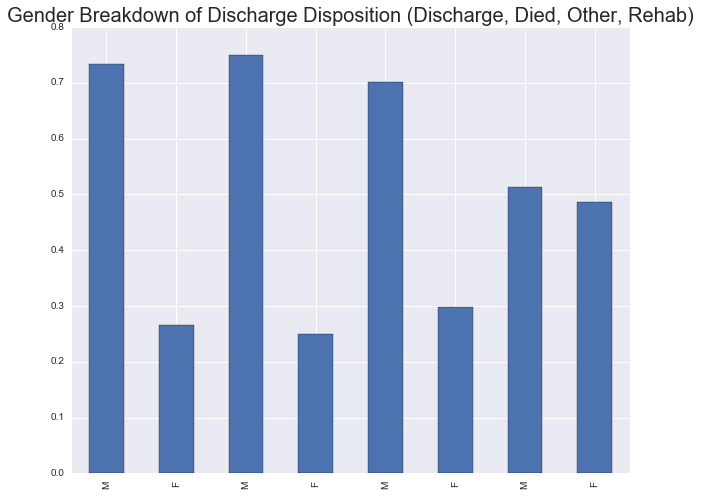

In [98]:
DischargeSexVC = pd.concat([Discharge.value_counts()/1072 ,Died.value_counts()/56 ,Other.value_counts()/275, Rehab.value_counts()/117])
#pd.concat([fallPatients['Sex'].value_counts()/511, notFallPatients['Sex'].value_counts()/1009], axis=1)
plt.title("Gender Breakdown of Discharge Disposition (Discharge, Died, Other, Rehab)", fontsize=20)
plt.rcParams['figure.figsize'] = (10,8)
DischargeSexVC.plot(kind="bar");

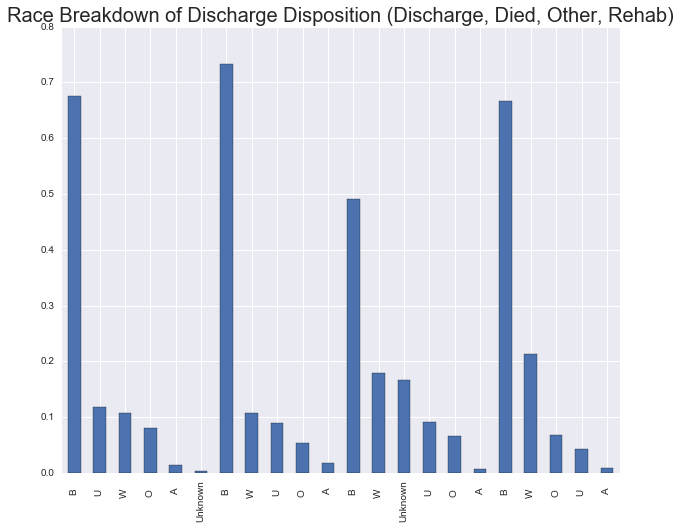

In [99]:
# Race
Discharge = pd.DataFrame(fullDF[fullDF["Discharge Disposition Buckets"]=="Discharged Home (routine)"]).reset_index(drop=True)
Died = pd.DataFrame(fullDF[fullDF["Discharge Disposition Buckets"]=="Died"]).reset_index(drop=True)
Other = pd.DataFrame(fullDF[fullDF["Discharge Disposition Buckets"]=="Other"]).reset_index(drop=True)
Rehab = pd.DataFrame(fullDF[fullDF["Discharge Disposition Buckets"]=="Rehabilitation"]).reset_index(drop=True)
Discharge = Discharge["Race"]
Died = Died["Race"]
Other = Other["Race"]
Rehab = Rehab["Race"]
DischargeSexVC = pd.concat([Discharge.value_counts()/1072 ,Died.value_counts()/56 ,Other.value_counts()/275, Rehab.value_counts()/117])
#pd.concat([fallPatients['Sex'].value_counts()/511, notFallPatients['Sex'].value_counts()/1009], axis=1)
plt.title("Race Breakdown of Discharge Disposition (Discharge, Died, Other, Rehab)", fontsize=20)
plt.rcParams['figure.figsize'] = (10,8)
DischargeSexVC.plot(kind="bar");

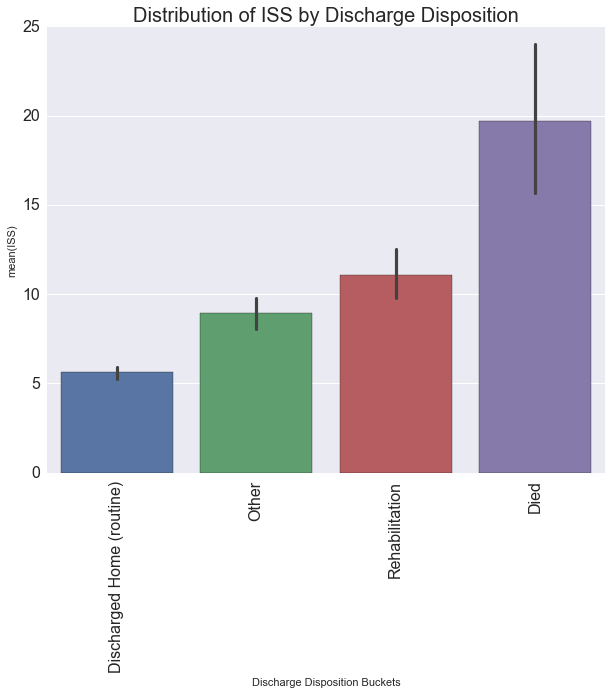

In [100]:
plt.rcParams['figure.figsize'] = (10,8)
plt.title("Distribution of ISS by Discharge Disposition", fontsize=20)
plt.xticks(rotation="90")
plt.tick_params(axis='both', which='major', labelsize=16)
sns.barplot(x=fullDF['Discharge Disposition Buckets'], y=fullDF['ISS'], data = fullDF);

# Random Forest regressor on LOS (minutes) using label encoder

In [101]:
# Create Model for DataFrame:
featuresDF = df.drop(["LOS (Days)","Arrival Date", "Arrival Time", 'ED D/C Date', 'ED D/C Time',
                    "Comorcode", "Injury Date", "Injury Street",
                     "Injury Zip", 'Combined D/C DateTime',"Dx List", 
                    "Consults", "ETOH Buckets Plot", "Discharge Disposition", 'Combined Arrival DateTime', 
                      "Length of Stay (hours)",
                     "Toxiclogy Buckets", "Admit Location Buckets", "Fall Height",
                     "Admit Service Buckets", "ED Disposition Buckets", "Fall Patient?",
                      "TTA Buckets", "Fall Height Buckets", "Length of Stay (minutes)", 'Arrival Hour', "ED D/C Hour",
                     "ETOH Buckets", "MOI"], axis = 1)

labelsSeries = df["Length of Stay (minutes)"]

fullDF = pd.concat([featuresDF, labelsSeries], axis=1)

encodedFullDF = pd.DataFrame()

In [102]:
# Encode Features:
featuresToEncode = ["Sex", "Race", "Injury Type", "Abuse?", "Work Related?", "ETOH", 'Admit Service',
                   "TTA", "ED Disposition", "GCS", "Injury Type", "Admit Service", "Admit Location", "ISS", \
                    "MOI Buckets", "Abuse?", "Work Related?", "Discharge Disposition Buckets", 
                   "Toxiclogy"]

for feature in featuresToEncode:
    featuresDF[feature] = LabelEncoder().fit_transform(featuresDF[feature])

for feature in fullDF:
    encodedFullDF[feature] = LabelEncoder().fit_transform(fullDF[feature])

In [103]:
# Scale Dataframes

encodedFullDFCols = encodedFullDF.columns
columns = featuresDF.columns
scaler = MinMaxScaler()

#scale features
featuresDF = scaler.fit_transform(featuresDF)
featuresDF = pd.DataFrame(columns=columns, data=featuresDF)


encodedFullDF = scaler.fit_transform(encodedFullDF)
encodedFullDF = pd.DataFrame(columns=encodedFullDFCols, data=encodedFullDF)

In [104]:
# Let's see what the feature importances are to reduce dimensionality:

X, y = featuresDF, labelsSeries

forest = RandomForestRegressor(n_estimators=250,
                              random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [105]:
s = cross_val_score(forest, featuresDF, labelsSeries, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest Cros Val", s.mean().round(3), s.std().round(3)))

Random Forest Cros Val Score:	0.154 ± 0.059


In [106]:
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature name: %s (%f)" % (f + 1, X.columns[f], importances[indices[f]]))

Feature ranking:
1. feature name: Age (0.277444)
2. feature name: Sex (0.129935)
3. feature name: Race (0.102643)
4. feature name: ISS (0.071515)
5. feature name: TTA (0.068404)
6. feature name: GCS (0.061248)
7. feature name: ED Disposition (0.044507)
8. feature name: Admit Service (0.040545)
9. feature name: Admit Location (0.040421)
10. feature name: Toxiclogy (0.037383)
11. feature name: ETOH (0.025403)
12. feature name: Injury Type (0.024758)
13. feature name: Abuse? (0.024497)
14. feature name: Work Related? (0.021455)
15. feature name: Discharge Disposition Buckets (0.016463)
16. feature name: MOI Buckets (0.013378)


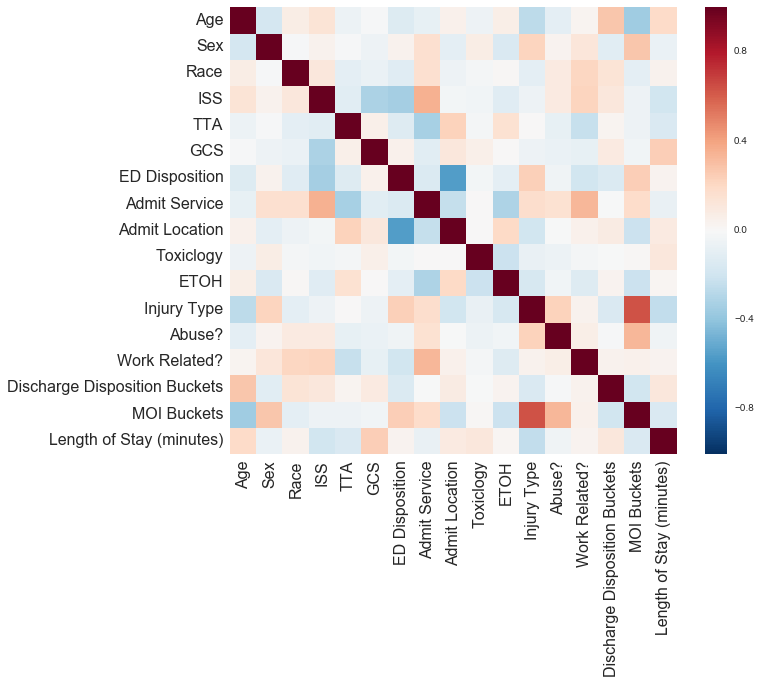

In [107]:
plt.rcParams['figure.figsize'] = (10,8)
plt.tick_params(axis='both', which='major', labelsize=16)
sns.heatmap(encodedFullDF.corr());

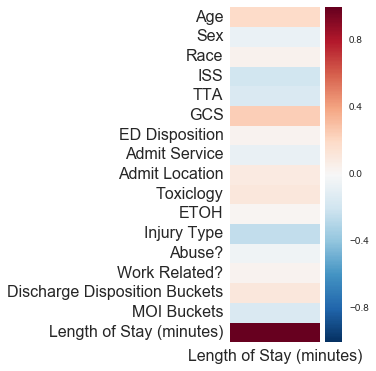

In [108]:
plt.rcParams['figure.figsize'] = (2,6)
plt.tick_params(axis='both', which='major', labelsize=16)
sns.heatmap(encodedFullDF.corr().ix["Length of Stay (minutes)"].to_frame());

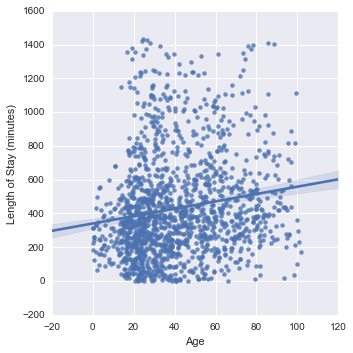

In [109]:
plt.rcParams['figure.figsize'] = (20,16)
sns.lmplot('Age', "Length of Stay (minutes)", data=fullDF);

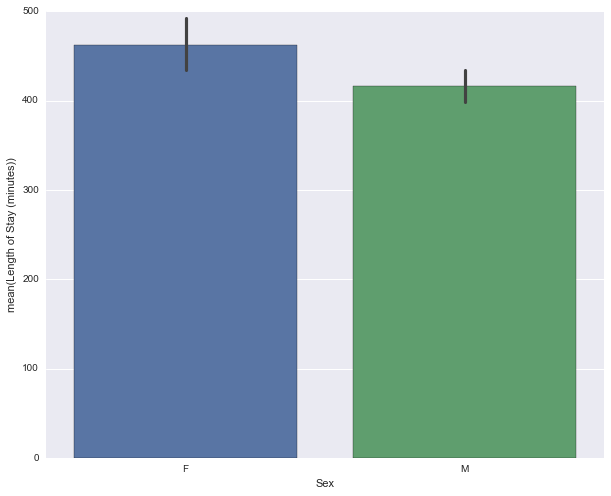

In [110]:
plt.rcParams['figure.figsize'] = (10,8)
sns.barplot('Sex', "Length of Stay (minutes)", data=fullDF);

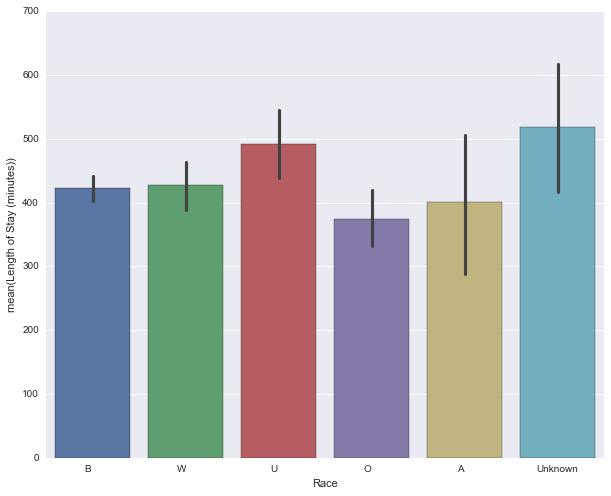

In [111]:
plt.rcParams['figure.figsize'] = (10,8)
sns.barplot('Race', "Length of Stay (minutes)", data=fullDF);